## Importing Libraries

In [2]:
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import time
import copy
import numpy as np
from tqdm import tqdm
from clampfloat import *
from datasets import load_dataset
from dataclasses import dataclass, field
from transformers import GPT2Tokenizer, GPT2Model
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, BertTokenizer,BertForMaskedLM

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def set_random_seeds(random_seed=0):

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

## Dataset and DataLoaders

In [6]:
batch_size = 32

In [7]:
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )])

In [8]:
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size)

## Helper Functions for Imagenet Models

In [10]:
def evaluate_model(model, test_loader, device):

    model.eval()
    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct/total

In [11]:
def measure_inference_latency(model, device, input_size=(1, 3, 224, 224), num_samples=100, num_warmups=10):

    model.to(device)
    model.eval()

    x = torch.rand(size=input_size).to(device)

    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(x)
    torch.cuda.synchronize()

    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_samples):
            _ = model(x)
            torch.cuda.synchronize()
        end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_ave = elapsed_time / num_samples

    return elapsed_time_ave

## Custom Float Class

In [12]:
@dataclass
class CustomFloat:
    signed: bool = True
    exponent: int = 8
    mantisa: int = 23

In [13]:
def quantizemodel(model: torch.nn.Module, cfloat: CustomFloat,
                    allowLayerClamp = True, fixBias = True):
    
    for param in model.parameters():
        param.requires_grad = True

    if not allowLayerClamp:
        return
    
    on = 1 if cfloat.signed else 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            if ("bias" in name and fixBias):
                hData = param.data.detach().numpy()
                vec_clamp_float(hData,on,cfloat.exponent,cfloat.mantisa)
                param.data = nn.Parameter(torch.from_numpy(hData))
            elif("weight" in name):
                hData = param.data.detach().numpy()
                vec_clamp_float(hData,on,cfloat.exponent,cfloat.mantisa)
                param.data = nn.Parameter(torch.from_numpy(hData))


## Quantizing Imagenet Models

### 1. AlexNet

In [13]:
alexnet = torch.load("models/alexnet.pt")
alexnet.to(cpu_device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
man_bits = np.arange(1, 24, 2)
exp_bits = np.arange(1, 9, 2)

for m_bits in man_bits:
    for e_bits in exp_bits:
        model = copy.deepcopy(alexnet)
        model.to(cpu_device)
        model.train()
        floatinfo = CustomFloat(True, e_bits, m_bits)
        quantizemodel(model, floatinfo)
        torch.save(model, "models/quantized_models/alexnets/alexnet_1_{}_{}.pt".format(e_bits, m_bits))

### 2. ResNet50

In [16]:
resnet50 = torch.load("models/resnet50.pt")
resnet50.to(cpu_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
man_bits = np.arange(1, 24, 2)
exp_bits = np.arange(1, 9, 2)

for m_bits in man_bits:
    for e_bits in exp_bits:
        model = copy.deepcopy(resnet50)
        model.to(cpu_device)
        model.train()
        floatinfo = CustomFloat(True, e_bits, m_bits)
        quantizemodel(model, floatinfo)
        torch.save(model, "models/quantized_models/resnets/resnet50_1_{}_{}.pt".format(e_bits, m_bits))

### 3. VGG19

In [ ]:
vgg19 = torch.load("models/vgg19.pt")
vgg19.to(cpu_device)

In [ ]:
man_bits = np.arange(1, 24, 2)
exp_bits = np.arange(1, 9, 2)

for m_bits in man_bits:
    for e_bits in exp_bits:
        model = copy.deepcopy(vgg19)
        model.to(cpu_device)
        model.train()
        floatinfo = CustomFloat(True, e_bits, m_bits)
        quantizemodel(model, floatinfo)
        torch.save(model, "models/quantized_models/vgg19s/vgg19_1_{}_{}.pt".format(e_bits, m_bits))

## Evaluating Quantized Imagenet Models

In [14]:
def run(device, model, quantized_model_dir, model_series_name, test_loader, output_fname):
    f = open(output_fname, "w")

    print(f"##################### {model_series_name} model #####################")
    f.write(f"##################### {model_series_name} model #####################\n")
    # Accuracy
    acc = evaluate_model(model, test_loader, device)
    print("Unquantized (FP32) {} Model evaluation accuracy: {:.3f}".format(model_series_name, acc))
    f.write("Unquantized (FP32) {} Model evaluation accuracy: {:.3f}\n".format(model_series_name, acc))
    # Latency
    latency = measure_inference_latency(model, device)
    print("Unquantized (FP32) {} Model {} latency: {:.2f} ms / sample".format(model_series_name, device, latency * 1000))
    f.write("Unquantized (FP32) {} Model {} latency: {:.2f} ms / sample\n".format(model_series_name, device, latency * 1000))

    man_bits = np.arange(1, 24, 2)
    exp_bits = np.arange(1, 9, 2)

    qacc = np.zeros((len(man_bits), len(exp_bits)))
    qlatency = np.zeros((len(man_bits), len(exp_bits)))

    for i,m_bits in enumerate(man_bits):
        for j,e_bits in enumerate(exp_bits):
            model_path = quantized_model_dir + f"/{model_series_name}_1_{e_bits}_{m_bits}.pt"
            qmodel = torch.load(model_path)
            qacc[i][j] = evaluate_model(qmodel, test_loader, device)
            print("Quantized (s: 1 e: {} m: {}) {} Model evaluation accuracy: {:.3f}".format(e_bits, m_bits, model_series_name, qacc[i][j]))
            f.write("Quantized (s: 1 e: {} m: {}) {} Model evaluation accuracy: {:.3f}\n".format(e_bits, m_bits, model_series_name, qacc[i][j]))
            qlatency[i][j] = measure_inference_latency(model, device)
            print("Quantized (s: 1 e: {} m: {}) {} Model {} latency: {:.2f} ms / sample".format(e_bits, m_bits, model_series_name, device, qlatency[i][j] * 1000))
            f.write("Quantized (s: 1 e: {} m: {}) {} Model {} latency: {:.2f} ms / sample\n".format(e_bits, m_bits, model_series_name, device, qlatency[i][j] * 1000))

    f.close()

    return acc, latency, qacc, qlatency

### 1. Alexnet

In [20]:
# For alexnet
alexnet = torch.load("models/alexnet.pt")
quantized_model_dir = "models/quantized_models/alexnets"
model_series_name = "alexnet"
output_fname = "alexnet_analysis.txt"

alexnet_acc, alexnet_latency, alexnet_qacc, alexnet_qlatency = run(cuda_device, alexnet, quantized_model_dir, model_series_name, test_loader, output_fname)

##################### alexnet model #####################
Unquantized (FP32) alexnet Model evaluation accuracy: 0.849
Unquantized (FP32) alexnet Model cuda:0 latency: 2.50 ms / sample
Quantized (s: 1 e: 1 m: 1) alexnet Model evaluation accuracy: 0.107
Quantized (s: 1 e: 1 m: 1) alexnet Model cuda:0 latency: 2.59 ms / sample
Quantized (s: 1 e: 3 m: 1) alexnet Model evaluation accuracy: 0.098
Quantized (s: 1 e: 3 m: 1) alexnet Model cuda:0 latency: 4.70 ms / sample
Quantized (s: 1 e: 5 m: 1) alexnet Model evaluation accuracy: 0.730
Quantized (s: 1 e: 5 m: 1) alexnet Model cuda:0 latency: 2.64 ms / sample
Quantized (s: 1 e: 7 m: 1) alexnet Model evaluation accuracy: 0.730
Quantized (s: 1 e: 7 m: 1) alexnet Model cuda:0 latency: 2.65 ms / sample
Quantized (s: 1 e: 1 m: 3) alexnet Model evaluation accuracy: 0.108
Quantized (s: 1 e: 1 m: 3) alexnet Model cuda:0 latency: 2.59 ms / sample
Quantized (s: 1 e: 3 m: 3) alexnet Model evaluation accuracy: 0.105
Quantized (s: 1 e: 3 m: 3) alexnet Mod

In [21]:
f = open("alexnet_results.txt", "w")
f.write(str(alexnet_acc))
f.write("\n")
f.write(str(alexnet_latency))
f.write("\n")
f.write(str(alexnet_qacc))
f.write("\n")
f.write(str(alexnet_qlatency))
f.write("\n")
f.close()

In [74]:
with open("alexnet_state.npy", "wb") as f:
    np.save(f, np.array(alexnet_acc))
    np.save(f, np.array(alexnet_latency))
    np.save(f, alexnet_qacc)
    np.save(f, alexnet_qlatency)

### 2. Resnet50

In [81]:
# For resnet
resnet50 = torch.load("models/resnet50.pt")
quantized_model_dir = "models/quantized_models/resnets"
model_series_name = "resnet50"
output_fname = "resnet50_analysis.txt"
resnet50_acc, resnet50_latency, resnet50_qacc, resnet50_qlatency = run(cuda_device, resnet50, quantized_model_dir, model_series_name, test_loader, output_fname)

##################### resnet50 model #####################
Unquantized (FP32) resnet50 Model evaluation accuracy: 0.791
Unquantized (FP32) resnet50 Model cuda:0 latency: 7.81 ms / sample
Quantized (s: 1 e: 1 m: 1) resnet50 Model evaluation accuracy: 0.100
Quantized (s: 1 e: 1 m: 1) resnet50 Model cuda:0 latency: 8.91 ms / sample
Quantized (s: 1 e: 3 m: 1) resnet50 Model evaluation accuracy: 0.100
Quantized (s: 1 e: 3 m: 1) resnet50 Model cuda:0 latency: 10.15 ms / sample
Quantized (s: 1 e: 5 m: 1) resnet50 Model evaluation accuracy: 0.121
Quantized (s: 1 e: 5 m: 1) resnet50 Model cuda:0 latency: 12.46 ms / sample
Quantized (s: 1 e: 7 m: 1) resnet50 Model evaluation accuracy: 0.121
Quantized (s: 1 e: 7 m: 1) resnet50 Model cuda:0 latency: 12.72 ms / sample
Quantized (s: 1 e: 1 m: 3) resnet50 Model evaluation accuracy: 0.100
Quantized (s: 1 e: 1 m: 3) resnet50 Model cuda:0 latency: 20.07 ms / sample
Quantized (s: 1 e: 3 m: 3) resnet50 Model evaluation accuracy: 0.100
Quantized (s: 1 e: 3

In [82]:
f = open("resnet50_results.txt", "w")
f.write(str(resnet50_acc))
f.write("\n")
f.write(str(resnet50_latency))
f.write("\n")
f.write(str(resnet50_qacc))
f.write("\n")
f.write(str(resnet50_qlatency))
f.write("\n")
f.close()

In [83]:
with open("resnet50_state.npy", "wb") as f:
    np.save(f, np.array(resnet50_acc))
    np.save(f, np.array(resnet50_latency))
    np.save(f, resnet50_qacc)
    np.save(f, resnet50_qlatency)

### 3. VGG19

In [ ]:
# For vgg19
vgg19 = torch.load("models/vgg19.pt")
quantized_model_dir = "models/quantized_models/vgg19s"
model_series_name = "vgg19"
output_fname = "vgg19_analysis.txt"
vgg19_acc, vgg19_latency, vgg19_qacc, vgg19_qlatency = run(cpu_device, vgg19, quantized_model_dir, model_series_name, test_loader, output_fname)

In [ ]:
f = open("vgg19_results.txt", "w")
f.write(str(vgg19_acc))
f.write("\n")
f.write(str(vgg19_latency))
f.write("\n")
f.write(str(vgg19_qacc))
f.write("\n")
f.write(str(vgg19_qlatency))
f.write("\n")
f.close()

## Helper Functions for Language Models

In [34]:
def eval_language_model(model, model_name, device, encodings, stride = 512):

    model.to(device)

    if 'gpt2' in model_name: 
        max_length = model.config.n_positions
    else:
        max_length = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over input tokens.
            # Multiply it with trg_len to get the summation instead of average.
            # We will take average over all the tokens to get the true average
            # in the last step of this example.
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)

    return ppl.data.detach().cpu().numpy()

In [35]:
def run_language_model(device, model, quantized_model_dir, model_series_name, encodings, output_fname):
    f = open(output_fname, "w")

    print(f"##################### {model_series_name} model #####################")
    f.write(f"##################### {model_series_name} model #####################\n")
    # Accuracy
    ppl = eval_language_model(model, model_series_name, device, encodings)
    print("Unquantized (FP32) {} Model perplexity: {:.3f}".format(model_series_name, ppl))
    f.write("Unquantized (FP32) {} Model perplexity: {:.3f}\n".format(model_series_name, ppl))

    man_bits = np.arange(1, 24, 2)
    exp_bits = np.arange(1, 9, 2)

    qppl = np.zeros((len(man_bits), len(exp_bits)))

    for i,m_bits in enumerate(man_bits):
        for j,e_bits in enumerate(exp_bits):
            model_path = quantized_model_dir + f"/{model_series_name}_1_{e_bits}_{m_bits}.pt"
            qmodel = torch.load(model_path)
            qppl[i][j] = eval_language_model(qmodel, model_series_name, device, encodings)
            print("Quantized (s: 1 e: {} m: {}) {} Model perplexity: {:.3f}".format(e_bits, m_bits, model_series_name, qppl[i][j]))
            f.write("Quantized (s: 1 e: {} m: {}) {} Model perplexity: {:.3f}\n".format(e_bits, m_bits, model_series_name, qppl[i][j]))
            
    f.close()

    return ppl, qppl

### 1. GPT 2 model

In [41]:
model_id = "gpt2"
gpt2 = GPT2LMHeadModel.from_pretrained(model_id).to(device)

In [42]:
torch.save(gpt2, "models/gpt2.pt")

In [25]:
man_bits = np.arange(1, 24, 2)
exp_bits = np.arange(1, 9, 2)

for m_bits in man_bits:
    for e_bits in exp_bits:
        model = copy.deepcopy(gpt2)
        model.to(cpu_device)
        model.train()
        floatinfo = CustomFloat(True, e_bits, m_bits)
        quantizemodel(model, floatinfo)
        torch.save(model, "models/quantized_models/gpt2/gpt2_1_{}_{}.pt".format(e_bits, m_bits))

In [43]:
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [44]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Found cached dataset wikitext (C:/Users/Madhan/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
Token indices sequence length is longer than the specified maximum sequence length for this model (287644 > 1024). Running this sequence through the model will result in indexing errors


In [45]:
# For gpt2
gpt2 = torch.load("models/gpt2.pt")
quantized_model_dir = "models/quantized_models/gpt2"
model_series_name = "gpt2"
output_fname = "gpt2_analysis.txt"
gpt2_ppl, gpt2_qppl = run_language_model(cuda_device, gpt2, quantized_model_dir, model_series_name, encodings, output_fname)

##################### gpt2 model #####################


100%|█████████▉| 560/562 [01:36<00:00,  5.78it/s]


Unquantized (FP32) gpt2 Model perplexity: 25.170


100%|█████████▉| 560/562 [02:07<00:00,  4.38it/s]


Quantized (s: 1 e: 1 m: 1) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [02:40<00:00,  3.48it/s]


Quantized (s: 1 e: 3 m: 1) gpt2 Model perplexity: 21267248.000


100%|█████████▉| 560/562 [03:10<00:00,  2.94it/s]


Quantized (s: 1 e: 5 m: 1) gpt2 Model perplexity: 611.648


100%|█████████▉| 560/562 [03:27<00:00,  2.70it/s]


Quantized (s: 1 e: 7 m: 1) gpt2 Model perplexity: 611.878


100%|█████████▉| 560/562 [03:27<00:00,  2.70it/s]


Quantized (s: 1 e: 1 m: 3) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:41<00:00,  2.52it/s]


Quantized (s: 1 e: 3 m: 3) gpt2 Model perplexity: 1187011712.000


100%|█████████▉| 560/562 [03:52<00:00,  2.41it/s]


Quantized (s: 1 e: 5 m: 3) gpt2 Model perplexity: 38.518


100%|█████████▉| 560/562 [03:54<00:00,  2.39it/s]


Quantized (s: 1 e: 7 m: 3) gpt2 Model perplexity: 38.530


100%|█████████▉| 560/562 [03:44<00:00,  2.49it/s]


Quantized (s: 1 e: 1 m: 5) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [04:05<00:00,  2.28it/s]


Quantized (s: 1 e: 3 m: 5) gpt2 Model perplexity: 4621426176.000


100%|█████████▉| 560/562 [03:58<00:00,  2.34it/s]


Quantized (s: 1 e: 5 m: 5) gpt2 Model perplexity: 32.900


100%|█████████▉| 560/562 [03:51<00:00,  2.42it/s]


Quantized (s: 1 e: 7 m: 5) gpt2 Model perplexity: 32.965


100%|█████████▉| 560/562 [03:50<00:00,  2.43it/s]


Quantized (s: 1 e: 1 m: 7) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:51<00:00,  2.42it/s]


Quantized (s: 1 e: 3 m: 7) gpt2 Model perplexity: 7030213120.000


100%|█████████▉| 560/562 [04:02<00:00,  2.31it/s]


Quantized (s: 1 e: 5 m: 7) gpt2 Model perplexity: 33.141


100%|█████████▉| 560/562 [04:29<00:00,  2.08it/s]


Quantized (s: 1 e: 7 m: 7) gpt2 Model perplexity: 33.036


100%|█████████▉| 560/562 [04:22<00:00,  2.13it/s]


Quantized (s: 1 e: 1 m: 9) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [04:25<00:00,  2.11it/s]


Quantized (s: 1 e: 3 m: 9) gpt2 Model perplexity: 7429975552.000


100%|█████████▉| 560/562 [04:11<00:00,  2.22it/s]


Quantized (s: 1 e: 5 m: 9) gpt2 Model perplexity: 33.090


100%|█████████▉| 560/562 [04:07<00:00,  2.26it/s]


Quantized (s: 1 e: 7 m: 9) gpt2 Model perplexity: 33.107


100%|█████████▉| 560/562 [03:58<00:00,  2.35it/s]


Quantized (s: 1 e: 1 m: 11) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:58<00:00,  2.35it/s]


Quantized (s: 1 e: 3 m: 11) gpt2 Model perplexity: 7673303552.000


100%|█████████▉| 560/562 [03:53<00:00,  2.40it/s]


Quantized (s: 1 e: 5 m: 11) gpt2 Model perplexity: 33.217


100%|█████████▉| 560/562 [03:56<00:00,  2.37it/s]


Quantized (s: 1 e: 7 m: 11) gpt2 Model perplexity: 33.238


100%|█████████▉| 560/562 [03:46<00:00,  2.47it/s]


Quantized (s: 1 e: 1 m: 13) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:56<00:00,  2.36it/s]


Quantized (s: 1 e: 3 m: 13) gpt2 Model perplexity: 7789413888.000


100%|█████████▉| 560/562 [03:46<00:00,  2.48it/s]


Quantized (s: 1 e: 5 m: 13) gpt2 Model perplexity: 33.388


100%|█████████▉| 560/562 [03:45<00:00,  2.48it/s]


Quantized (s: 1 e: 7 m: 13) gpt2 Model perplexity: 33.284


100%|█████████▉| 560/562 [03:52<00:00,  2.41it/s]


Quantized (s: 1 e: 1 m: 15) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [04:10<00:00,  2.24it/s]


Quantized (s: 1 e: 3 m: 15) gpt2 Model perplexity: 7664614400.000


100%|█████████▉| 560/562 [04:10<00:00,  2.24it/s]


Quantized (s: 1 e: 5 m: 15) gpt2 Model perplexity: 33.222


100%|█████████▉| 560/562 [04:07<00:00,  2.26it/s]


Quantized (s: 1 e: 7 m: 15) gpt2 Model perplexity: 33.229


100%|█████████▉| 560/562 [03:59<00:00,  2.34it/s]


Quantized (s: 1 e: 1 m: 17) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:57<00:00,  2.35it/s]


Quantized (s: 1 e: 3 m: 17) gpt2 Model perplexity: 7783606784.000


100%|█████████▉| 560/562 [03:53<00:00,  2.40it/s]


Quantized (s: 1 e: 5 m: 17) gpt2 Model perplexity: 33.295


100%|█████████▉| 560/562 [03:24<00:00,  2.74it/s]


Quantized (s: 1 e: 7 m: 17) gpt2 Model perplexity: 33.342


100%|█████████▉| 560/562 [03:24<00:00,  2.73it/s]


Quantized (s: 1 e: 1 m: 19) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:22<00:00,  2.76it/s]


Quantized (s: 1 e: 3 m: 19) gpt2 Model perplexity: 7909001216.000


100%|█████████▉| 560/562 [03:23<00:00,  2.76it/s]


Quantized (s: 1 e: 5 m: 19) gpt2 Model perplexity: 33.220


100%|█████████▉| 560/562 [03:25<00:00,  2.73it/s]


Quantized (s: 1 e: 7 m: 19) gpt2 Model perplexity: 33.275


100%|█████████▉| 560/562 [03:17<00:00,  2.83it/s]


Quantized (s: 1 e: 1 m: 21) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:29<00:00,  2.67it/s]


Quantized (s: 1 e: 3 m: 21) gpt2 Model perplexity: 7420457984.000


100%|█████████▉| 560/562 [03:23<00:00,  2.75it/s]


Quantized (s: 1 e: 5 m: 21) gpt2 Model perplexity: 33.310


100%|█████████▉| 560/562 [03:24<00:00,  2.73it/s]


Quantized (s: 1 e: 7 m: 21) gpt2 Model perplexity: 33.306


100%|█████████▉| 560/562 [03:13<00:00,  2.89it/s]


Quantized (s: 1 e: 1 m: 23) gpt2 Model perplexity: inf


100%|█████████▉| 560/562 [03:21<00:00,  2.78it/s]


Quantized (s: 1 e: 3 m: 23) gpt2 Model perplexity: 7866680320.000


100%|█████████▉| 560/562 [03:30<00:00,  2.66it/s]


Quantized (s: 1 e: 5 m: 23) gpt2 Model perplexity: 33.321


100%|█████████▉| 560/562 [03:26<00:00,  2.71it/s]

Quantized (s: 1 e: 7 m: 23) gpt2 Model perplexity: 33.328


In [46]:
f = open("gpt2_results.txt", "w")
f.write(str(gpt2_ppl))
f.write("\n")
f.write(str(gpt2_qppl))
f.write("\n")
f.close()

In [77]:
with open("gpt2_state.npy", "wb") as f:
    np.save(f, np.array(gpt2_ppl.data.detach().cpu().numpy()))
    np.save(f, gpt2_qppl)


### 2. BERT Model

In [30]:
bert_large_cased = BertForMaskedLM.from_pretrained('bert-large-cased')

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
torch.save(bert_large_cased, "models/bert_large_cased.pt")

In [47]:
bert_large_cased = torch.load("models/bert_large_cased.pt")

In [16]:
man_bits = np.arange(1, 24, 2)
exp_bits = np.arange(1, 9, 2)

for m_bits in man_bits:
    for e_bits in exp_bits:
        model = copy.deepcopy(bert_large_cased)
        model.to(cpu_device)
        model.train()
        floatinfo = CustomFloat(True, e_bits, m_bits)
        quantizemodel(model, floatinfo)
        torch.save(model, "models/quantized_models/bert_large_cased/bert_large_cased_1_{}_{}.pt".format(e_bits, m_bits))

In [48]:
tokenizer = BertTokenizer.from_pretrained('bert-large-cased')
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (281597 > 512). Running this sequence through the model will result in indexing errors


In [49]:
# For BERT
bert_large_cased = torch.load("models/bert_large_cased.pt")
quantized_model_dir = "models/quantized_models/bert_large_cased"
model_series_name = "bert_large_cased"
output_fname = "bert_large_cased_analysis.txt"
bert_large_cased_ppl, bert_large_cased_qppl = run_language_model(cuda_device, bert_large_cased, quantized_model_dir, model_series_name, encodings, output_fname)

##################### bert_large_cased model #####################


100%|█████████▉| 549/550 [03:16<00:00,  2.79it/s]


Unquantized (FP32) bert_large_cased Model perplexity: 1.434


100%|█████████▉| 549/550 [03:07<00:00,  2.93it/s]


Quantized (s: 1 e: 1 m: 1) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:16<00:00,  2.80it/s]


Quantized (s: 1 e: 3 m: 1) bert_large_cased Model perplexity: 134374326534144.000


100%|█████████▉| 549/550 [03:19<00:00,  2.75it/s]


Quantized (s: 1 e: 5 m: 1) bert_large_cased Model perplexity: 2440.594


100%|█████████▉| 549/550 [03:22<00:00,  2.71it/s]


Quantized (s: 1 e: 7 m: 1) bert_large_cased Model perplexity: 2404.482


100%|█████████▉| 549/550 [03:10<00:00,  2.88it/s]


Quantized (s: 1 e: 1 m: 3) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:34<00:00,  2.56it/s]


Quantized (s: 1 e: 3 m: 3) bert_large_cased Model perplexity: 189693741798260736.000


100%|█████████▉| 549/550 [03:18<00:00,  2.76it/s]


Quantized (s: 1 e: 5 m: 3) bert_large_cased Model perplexity: 1.592


100%|█████████▉| 549/550 [03:17<00:00,  2.77it/s]


Quantized (s: 1 e: 7 m: 3) bert_large_cased Model perplexity: 1.587


100%|█████████▉| 549/550 [03:10<00:00,  2.88it/s]


Quantized (s: 1 e: 1 m: 5) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:30<00:00,  2.61it/s]


Quantized (s: 1 e: 3 m: 5) bert_large_cased Model perplexity: 1746448601518702592.000


100%|█████████▉| 549/550 [03:24<00:00,  2.68it/s]


Quantized (s: 1 e: 5 m: 5) bert_large_cased Model perplexity: 1.574


100%|█████████▉| 549/550 [03:25<00:00,  2.67it/s]


Quantized (s: 1 e: 7 m: 5) bert_large_cased Model perplexity: 1.575


100%|█████████▉| 549/550 [03:14<00:00,  2.82it/s]


Quantized (s: 1 e: 1 m: 7) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:18<00:00,  2.77it/s]


Quantized (s: 1 e: 3 m: 7) bert_large_cased Model perplexity: 3387636556863897600.000


100%|█████████▉| 549/550 [03:17<00:00,  2.78it/s]


Quantized (s: 1 e: 5 m: 7) bert_large_cased Model perplexity: 1.580


100%|█████████▉| 549/550 [03:27<00:00,  2.64it/s]


Quantized (s: 1 e: 7 m: 7) bert_large_cased Model perplexity: 1.581


100%|█████████▉| 549/550 [03:07<00:00,  2.93it/s]


Quantized (s: 1 e: 1 m: 9) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:25<00:00,  2.67it/s]


Quantized (s: 1 e: 3 m: 9) bert_large_cased Model perplexity: 3903461441918730240.000


100%|█████████▉| 549/550 [03:21<00:00,  2.73it/s]


Quantized (s: 1 e: 5 m: 9) bert_large_cased Model perplexity: 1.587


100%|█████████▉| 549/550 [03:26<00:00,  2.66it/s]


Quantized (s: 1 e: 7 m: 9) bert_large_cased Model perplexity: 1.586


100%|█████████▉| 549/550 [03:11<00:00,  2.87it/s]


Quantized (s: 1 e: 1 m: 11) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:21<00:00,  2.72it/s]


Quantized (s: 1 e: 3 m: 11) bert_large_cased Model perplexity: 4250263627115790336.000


100%|█████████▉| 549/550 [03:15<00:00,  2.80it/s]


Quantized (s: 1 e: 5 m: 11) bert_large_cased Model perplexity: 1.590


100%|█████████▉| 549/550 [03:25<00:00,  2.67it/s]


Quantized (s: 1 e: 7 m: 11) bert_large_cased Model perplexity: 1.589


100%|█████████▉| 549/550 [03:06<00:00,  2.94it/s]


Quantized (s: 1 e: 1 m: 13) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:19<00:00,  2.75it/s]


Quantized (s: 1 e: 3 m: 13) bert_large_cased Model perplexity: 4207354086330204160.000


100%|█████████▉| 549/550 [03:20<00:00,  2.73it/s]


Quantized (s: 1 e: 5 m: 13) bert_large_cased Model perplexity: 1.589


100%|█████████▉| 549/550 [03:28<00:00,  2.63it/s]


Quantized (s: 1 e: 7 m: 13) bert_large_cased Model perplexity: 1.586


100%|█████████▉| 549/550 [03:11<00:00,  2.87it/s]


Quantized (s: 1 e: 1 m: 15) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:21<00:00,  2.73it/s]


Quantized (s: 1 e: 3 m: 15) bert_large_cased Model perplexity: 4373204145386029056.000


100%|█████████▉| 549/550 [03:24<00:00,  2.68it/s]


Quantized (s: 1 e: 5 m: 15) bert_large_cased Model perplexity: 1.587


100%|█████████▉| 549/550 [03:23<00:00,  2.70it/s]


Quantized (s: 1 e: 7 m: 15) bert_large_cased Model perplexity: 1.587


100%|█████████▉| 549/550 [03:08<00:00,  2.91it/s]


Quantized (s: 1 e: 1 m: 17) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:23<00:00,  2.70it/s]


Quantized (s: 1 e: 3 m: 17) bert_large_cased Model perplexity: 4343112986034962432.000


100%|█████████▉| 549/550 [03:23<00:00,  2.69it/s]


Quantized (s: 1 e: 5 m: 17) bert_large_cased Model perplexity: 1.590


100%|█████████▉| 549/550 [03:19<00:00,  2.76it/s]


Quantized (s: 1 e: 7 m: 17) bert_large_cased Model perplexity: 1.588


100%|█████████▉| 549/550 [03:11<00:00,  2.86it/s]


Quantized (s: 1 e: 1 m: 19) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:18<00:00,  2.77it/s]


Quantized (s: 1 e: 3 m: 19) bert_large_cased Model perplexity: 4231933668769136640.000


100%|█████████▉| 549/550 [03:28<00:00,  2.63it/s]


Quantized (s: 1 e: 5 m: 19) bert_large_cased Model perplexity: 1.590


100%|█████████▉| 549/550 [03:29<00:00,  2.63it/s]


Quantized (s: 1 e: 7 m: 19) bert_large_cased Model perplexity: 1.592


100%|█████████▉| 549/550 [03:09<00:00,  2.90it/s]


Quantized (s: 1 e: 1 m: 21) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:27<00:00,  2.65it/s]


Quantized (s: 1 e: 3 m: 21) bert_large_cased Model perplexity: 4280919935443533824.000


100%|█████████▉| 549/550 [03:17<00:00,  2.78it/s]


Quantized (s: 1 e: 5 m: 21) bert_large_cased Model perplexity: 1.594


100%|█████████▉| 549/550 [03:19<00:00,  2.75it/s]


Quantized (s: 1 e: 7 m: 21) bert_large_cased Model perplexity: 1.588


100%|█████████▉| 549/550 [03:07<00:00,  2.93it/s]


Quantized (s: 1 e: 1 m: 23) bert_large_cased Model perplexity: inf


100%|█████████▉| 549/550 [03:21<00:00,  2.73it/s]


Quantized (s: 1 e: 3 m: 23) bert_large_cased Model perplexity: 4331580483449126912.000


100%|█████████▉| 549/550 [03:24<00:00,  2.68it/s]


Quantized (s: 1 e: 5 m: 23) bert_large_cased Model perplexity: 1.588


100%|█████████▉| 549/550 [03:24<00:00,  2.69it/s]


Quantized (s: 1 e: 7 m: 23) bert_large_cased Model perplexity: 1.592


In [50]:
f = open("bert_large_cased_results.txt", "w")
f.write(str(bert_large_cased_ppl))
f.write("\n")
f.write(str(bert_large_cased_qppl))
f.write("\n")
f.close()

In [80]:
with open("bert_large_cased_state.npy", "wb") as f:
    np.save(f, np.array(bert_large_cased_ppl))
    np.save(f, bert_large_cased_qppl)

## Fixed Point Clamping for Imagenet Models

### 1. Alexnet

In [101]:
model1 = torch.load("models/quantized_models/alexnets/alexnet_1_7_21.pt")
model2 = torch.load("models/quantized_models/alexnets/alexnet_1_7_21.pt")


In [114]:
model1

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [110]:
def clamp_hook(self, input, output):
    s_bits = clamp_hook.s_bits
    e_bits = clamp_hook.e_bits
    m_bits = clamp_hook.m_bits

    np_output = output.detach().cpu().numpy()
    vec_clamp_float(np_output, s_bits, e_bits, m_bits)
    output = torch.Tensor(np_output)
    output.to(device)

def print_layer_inputs_hook(self, input, output):
    print(input)


In [111]:
clamp_hook.s_bits = 1
clamp_hook.e_bits = 7
clamp_hook.m_bits = 3

model1.features[0].register_forward_hook(clamp_hook)
model1.features[1].register_forward_hook(print_layer_inputs_hook)
model2.features[1].register_forward_hook(print_layer_inputs_hook)

In [ ]:
model1.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model1(images)
        break


In [ ]:
model2.to(device)
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        break

## Print Results

In [116]:
def printres(data, qdata, qdata2 = None, isqdata2 = False):
    man_bits = np.arange(1, 24, 2)
    exp_bits = np.arange(1, 9, 2)
    print("Unquantized {:.2f}".format(data))
    for i,m_bits in enumerate(man_bits):
        for j,e_bits in enumerate(exp_bits):
            if isqdata2 == True:
                print("{}\t{}\t{:.2f}\t{:.2f}".format(e_bits, m_bits, qdata[i][j]*100, qdata2[i][j]*1000))
            else:
                print("{}\t{}\t{:.2f}".format(e_bits, m_bits, qdata[i][j]))

In [130]:
def plotdata(zdata, zlabel):
    man_bits = np.arange(1, 24, 2)
    exp_bits = np.arange(1, 9, 2)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(exp_bits, man_bits)
    surf = ax.plot_surface(X, Y, zdata , cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.title('Weights and Bias floating point downclamping')
    ax.set_xlabel('num exponent bits')
    ax.set_ylabel('num significand bits')
    ax.set_zlabel(zlabel)
    plt.show()

def plotdata2(zdata, zlabel, zdata2, zlabel2):
    man_bits = np.arange(1, 24, 2)
    exp_bits = np.arange(1, 9, 2)
    fig = plt.figure(figsize=(12,7))
    X, Y = np.meshgrid(exp_bits, man_bits)
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax1.plot_surface(X, Y, zdata , cmap=cm.coolwarm, linewidth=0, antialiased=False)
    surf2 = ax2.plot_surface(X, Y, zdata2 , cmap=cm.coolwarm, linewidth=0, antialiased=False)
    plt.title('Weights and Bias floating point downclamping')
    ax1.set_xlabel('num exponent bits')
    ax1.set_ylabel('num significand bits')
    ax1.set_zlabel(zlabel)
    ax2.set_xlabel('num exponent bits')
    ax2.set_ylabel('num significand bits')
    ax2.set_zlabel(zlabel2)
    plt.show()

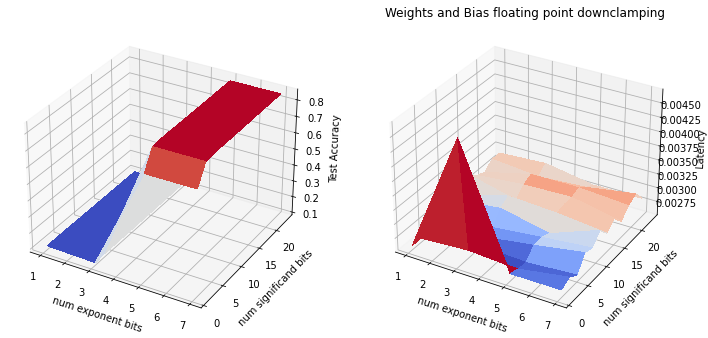

In [132]:
plotdata2(np.array(alexnet_qacc), "Test Accuracy", np.array(alexnet_qlatency), "Latency")

In [ ]:
printres(alexnet_acc, alexnet_qacc)

In [ ]:
printres(alexnet_latency, alexnet_qlatency)

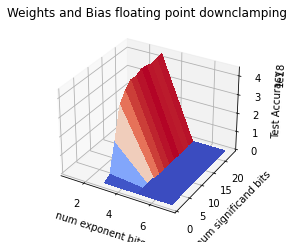

In [123]:
plotdata(np.array(bert_large_cased_qppl), "Test Accuracy")

In [ ]:
plotdata(alexnet_qlatency, "Latency")

In [89]:
def store_notebook_state(fname, alexnet_acc, alexnet_latency, alexnet_qacc, alexnet_qlatency, resnet50_acc, resnet50_latency, resnet50_qacc, resnet50_qlatency, gpt2_ppl, gpt2_qppl, bert_large_cased_ppl, bert_large_cased_qppl):
    with open(fname, "wb") as f:
        np.save(f, np.array(alexnet_acc))
        np.save(f, np.array(alexnet_latency))
        np.save(f, alexnet_qacc)
        np.save(f, alexnet_qlatency)
        np.save(f, np.array(resnet50_acc))
        np.save(f, np.array(resnet50_latency))
        np.save(f, resnet50_qacc)
        np.save(f, resnet50_qlatency)
        np.save(f, np.array(gpt2_ppl)) # .data.detach().cpu().numpy()
        np.save(f, gpt2_qppl)
        np.save(f, np.array(bert_large_cased_ppl))
        np.save(f, bert_large_cased_qppl)

In [90]:
def load_notebook_state(fname):
    with open(fname, "rb") as f:
        alexnet_acc = np.load(f)
        alexnet_latency = np.load(f)
        alexnet_qacc = np.load(f)
        alexnet_qlatency = np.load(f)
        resnet50_acc = np.load(f)
        resnet50_latency = np.load(f)
        resnet50_qacc = np.load(f)
        resnet50_qlatency = np.load(f)
        gpt2_ppl = np.load(f)
        gpt2_qppl = np.load(f)
        bert_large_cased_ppl = np.load(f)
        bert_large_cased_qppl = np.load(f)
    
    return alexnet_acc, alexnet_latency, alexnet_qacc, alexnet_qlatency, resnet50_acc, resnet50_latency, resnet50_qacc, resnet50_qlatency, gpt2_ppl, gpt2_qppl, bert_large_cased_ppl, bert_large_cased_qppl

In [100]:
fname = "notebook_state.npy"
store_notebook_state(fname, alexnet_acc, alexnet_latency, alexnet_qacc, alexnet_qlatency, resnet50_acc, resnet50_latency, resnet50_qacc, resnet50_qlatency, gpt2_ppl, gpt2_qppl, bert_large_cased_ppl, bert_large_cased_qppl)